##### https://curiousily.com/posts/time-series-classification-for-human-activity-recognition-with-lstms-in-keras/
##### https://colab.research.google.com/drive/1hxq4-A4SZYfKqmqfwP5Y0c01uElmnpq6#scrollTo=OhkOzpSt1vLA

## LSTM

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import StandardScaler, LabelEncoder


#%matplotlib inline
#%config InlineBackend.figure_format='retina'

#register_matplotlib_converters()
#sns.set(style='whitegrid', palette='muted', font_scale=1.5)

#rcParams['figure.figsize'] = 22, 10

#RANDOM_SEED = 42

#np.random.seed(RANDOM_SEED)
#tf.random.set_seed(RANDOM_SEED)

In [2]:
column_names = ['PacketCounter', 'Acc_X', 'Acc_Y', 'Acc_Z']

df = pd.read_csv('acc_data (right_wrist).csv')
print(df.head())
df = df.drop([0])
print(df.head())
#df['Acc_Z'] = df['Acc_Z'].astype(np.float64)

   PacketCounter     Acc_X     Acc_Y     Acc_Z Unnamed: 11
0              0  0.000000  0.000000  0.000000            
1              1 -8.874124 -0.679627  2.768368            
2              2 -8.873473 -0.613973  2.761706            
3              3 -8.834931 -0.518206  2.797576            
4              4 -8.921975 -0.508252  2.836315            
   PacketCounter     Acc_X     Acc_Y     Acc_Z Unnamed: 11
1              1 -8.874124 -0.679627  2.768368            
2              2 -8.873473 -0.613973  2.761706            
3              3 -8.834931 -0.518206  2.797576            
4              4 -8.921975 -0.508252  2.836315            
5              5 -8.999269 -0.533706  2.816627            


In [3]:
df.shape

(402, 5)

In [4]:
def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'g')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

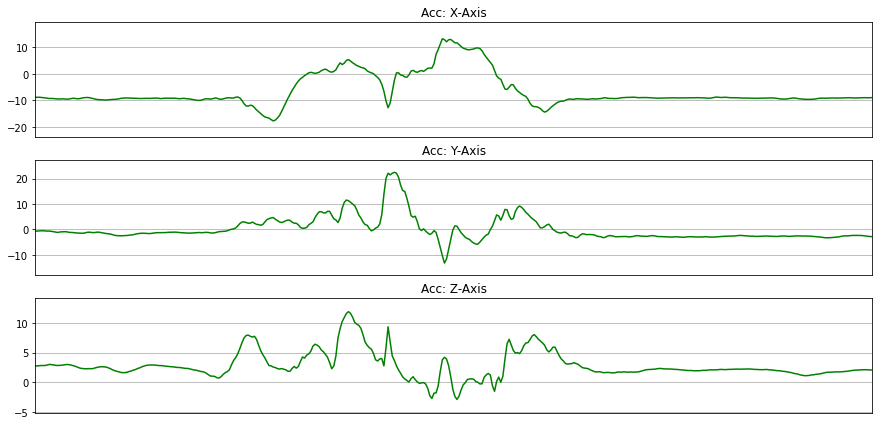

In [5]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 7), sharex=True)
plot_axis(ax0, df['PacketCounter'], df['Acc_X'], 'Acc: X-Axis')
plot_axis(ax1, df['PacketCounter'], df['Acc_Y'], 'Acc: Y-Axis')
plot_axis(ax2, df['PacketCounter'], df['Acc_Z'], 'Acc: Z-Axis')
plt.subplots_adjust(hspace=0.2)
plt.subplots_adjust(top=0.90)
plt.show()

In [6]:
#label = LabelEncoder()
#df['label'] = label.fit_transform(df['PacketCounter'])
#df.head()

In [7]:
X = df[['Acc_X', 'Acc_Y', 'Acc_Z']]
y = df['PacketCounter']

In [8]:
#df_train = df[df['PacketCounter'] <= 50]
#df_test = df[df['PacketCounter'] > 50]

#### Scale the accelerometer values

In [9]:
#from sklearn.preprocessing import RobustScaler

#scale_columns = ['Acc_X', 'Acc_Y', 'Acc_Z']

#scaler = RobustScaler()

#scaler = scaler.fit(df_train[scale_columns])

#df_train.loc[:, scale_columns] = scaler.transform(df_train[scale_columns].to_numpy())
#df_test.loc[:, scale_columns] = scaler.transform(df_test[scale_columns].to_numpy())

In [10]:
#X = df[['Acc_X', 'Acc_Y', 'Acc_Z']]
#y = df['label']

In [11]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

scaled_X = pd.DataFrame(data = X, columns = ['Acc_X', 'Acc_Y', 'Acc_Z'])
scaled_X['PacketCounter'] = y.values

scaled_X.head()

,Acc_X,Acc_Y,Acc_Z,PacketCounter
0,-0.376205,-0.153800,-0.018534,1
1,-0.376099,-0.139978,-0.021442,2
2,-0.369824,-0.119817,-0.005788,3
3,-0.383995,-0.117721,0.011117,4
4,-0.396579,-0.123080,0.002526,5


In [16]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = scaled_X['PacketCounter'].iloc[i: i + time_steps]
        Xs.append(v)        
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 200 #400 #200 #300
#STEP = 10  #100 #60 #80 #40 #150

X_train, y_train = create_dataset(
    df[['Acc_X', 'Acc_Y', 'Acc_Z']], 
    TIME_STEPS, 
    STEP
)

X_test, y_test = create_dataset(
    df[['Acc_X', 'Acc_Y', 'Acc_Z']], 
    TIME_STEPS, 
    STEP
)

In [17]:
print(X_train.shape, y_train.shape)

(392, 10, 3) (392, 1)


##### One hot encoding is one method of converting data to prepare it for an algorithm and get a better prediction. With one-hot, we convert each categorical value into a new categorical column and assign a binary value of 1 or 0 to those columns. Each integer value is represented as a binary vector

In [18]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)

In [19]:
print(X_train.shape, y_train.shape)

(392, 10, 3) (392, 392)


#### Classifying Activity

In [20]:
model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128, 
          input_shape=[X_train.shape[0], X_train.shape[1]]
      )
    )
)
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [21]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32, #64 #128 #32
    validation_split=0.1,
    shuffle=True
)

Train on 352 samples, validate on 40 samples
Epoch 1/100
352/352 [==============================] - 3s 8ms/sample - loss: 6.0544 - acc: 0.0028 - val_loss: 6.0921 - val_acc: 0.0000e+00
Epoch 2/100
352/352 [==============================] - 0s 193us/sample - loss: 5.9180 - acc: 0.0057 - val_loss: 6.1571 - val_acc: 0.0000e+00
Epoch 3/100
352/352 [==============================] - 0s 204us/sample - loss: 5.8159 - acc: 0.0256 - val_loss: 6.3155 - val_acc: 0.0000e+00
Epoch 4/100
352/352 [==============================] - 0s 195us/sample - loss: 5.6892 - acc: 0.0142 - val_loss: 6.6491 - val_acc: 0.0000e+00
Epoch 5/100
352/352 [==============================] - 0s 181us/sample - loss: 5.5309 - acc: 0.0085 - val_loss: 7.1140 - val_acc: 0.0000e+00
Epoch 6/100
352/352 [==============================] - 0s 178us/sample - loss: 5.3331 - acc: 0.0085 - val_loss: 7.6146 - val_acc: 0.0000e+00
Epoch 7/100
352/352 [==============================] - 0s 187us/sample - loss: 5.1372 - acc: 0.0256 - val_loss:

### Evaluation

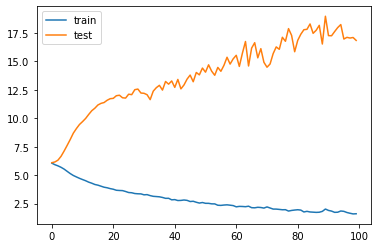

In [22]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

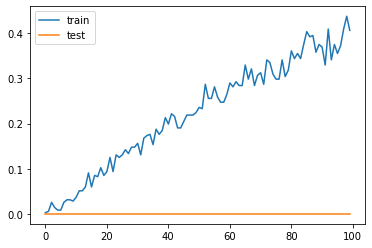

In [23]:
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend();

In [24]:
model.evaluate(X_test, y_test)

392/392 [==============================] - 0s 84us/sample - loss: 2.8836 - acc: 0.5408


[2.883639754081259, 0.5408163]

In [25]:
model.evaluate(X_train, y_train)

392/392 [==============================] - 0s 89us/sample - loss: 2.8836 - acc: 0.5408


[2.883639754081259, 0.5408163]

In [24]:
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, class_names):
  cm = confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots(figsize=(18, 16)) 
  ax = sns.heatmap(
      cm, 
      annot=True, 
      fmt="d", 
      cmap=sns.diverging_palette(220, 20, n=7),
      ax=ax
  )

  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(column_names)
  ax.set_yticklabels(column_names)
  b, t = plt.ylim() # discover the values for bottom and top
  b += 0.5 # Add 0.5 to the bottom
  t -= 0.5 # Subtract 0.5 from the top
  plt.ylim(b, t) # update the ylim(bottom, top) values
  plt.show() # ta-da!

In [ ]:
plot_cm(
  enc.inverse_transform(y_test),
  enc.inverse_transform(y_pred),
  enc.categories_[0]
)